In [25]:
import numpy as np
from cec2017.functions import f1
from charts import *
np.random.seed(0)

## Differential Evolution

In [26]:
class DE():
    def __init__(self, population:np.ndarray) -> None:
        self.population = population
        self.evaluation = f1(population)
        self.prev_evaluation = self.evaluation
        self.better_counter = 0
    def nextGeneration(self, F:float, CR:float, mutation_strategy:str) -> None:
        best_val = 0
        best = 0
        for individual in self.population:
            if best_val > np.average(f1([individual])):
                best_val = np.average(f1([individual]))
                best = individual
        for id, individual in enumerate(self.population):
            mutant_vector = self.mutate(F, mutation_strategy, best)
            recombined_individual = self.recombination(mutant_vector, individual, CR)
            self.selection(recombined_individual, id)
        return None
    def mutate(self, F:float, mutation_strategy:str, best:np.ndarray) -> np.ndarray:
        match mutation_strategy:
            case "rand/1":
                """
                Performs the 'rand/1' mutation strategy in Differential Evolution.
                """
                r1, r2, r3 = np.random.choice(len(self.population), size=3, replace=False)
                mutant_vector = self.population[r1] + F * (self.population[r2] - self.population[r3])
            case "best/1":
                """
                Performs the 'best/1' mutation strategy in Differential Evolution.
                """
                r1, r2 = np.random.choice(len(self.population), size=2, replace=False)
                mutant_vector = best + F * (self.population[r1] - self.population[r2])
            case "rand/2":
                """
                Performs the 'rand/2' mutation strategy in Differential Evolution.
                """
                r1, r2, r3, r4, r5 = np.random.choice(len(self.population), size=5, replace=False)
                mutant_vector = self.population[r1] + F * (self.population[r2] - self.population[r3]) \
                    + F * (self.population[r4] - self.population[r5])
            case "best/2":
                """
                Performs the 'best/2' mutation strategy in Differential Evolution.
                """
                r1, r2, r3, r4 = np.random.choice(len(self.population), size=4, replace=False)
                mutant_vector = best + F * (self.population[r1] - self.population[r2]) \
                    + F * (self.population[r3] - self.population[r4])
        return mutant_vector
    def recombination(self, mutator:np.ndarray, individual:np.ndarray, CR:float) -> np.ndarray:
        recombined_individual = np.array(individual)
        for attribute_id, attribute in enumerate(mutator):
            random_treshold = np.random.random()
            if random_treshold < CR:
                recombined_individual[attribute_id] = attribute
        return recombined_individual
    def selection(self, recombined_individual:np.ndarray, id:int) -> None:
        if f1([recombined_individual]) < f1([self.population[id]]):
            self.population[id] = recombined_individual
            self.better_counter += 1
        return None
    def evaluateChildren(self) -> float:
        percentage = self.better_counter/len(self.population)*100
        self.better_counter = 0
        return percentage
    def evaluateOptimum(self) -> float:
        summarized_diffrence = 0
        for individual in self.population:
            summarized_diffrence += abs(f1([individual]) - 100)
        return summarized_diffrence / len(self.population)

## Population

In [27]:
UPPER_BOUND = 100
DIMENSIONALITY = 50 #2 tylko ilustracyjnie, do eksperymentow 10 lub wiecej (30, 50, 100)
POPULATION = 100
#wylosuj punkt x:
population = np.random.uniform(-UPPER_BOUND, UPPER_BOUND, size=(POPULATION, DIMENSIONALITY))

## Q-learning

1 / 25, 4.0%
2 / 25, 8.0%
3 / 25, 12.0%
4 / 25, 16.0%
5 / 25, 20.0%
6 / 25, 24.0%
7 / 25, 28.000000000000004%
8 / 25, 32.0%
9 / 25, 36.0%
10 / 25, 40.0%
11 / 25, 44.0%
12 / 25, 48.0%
13 / 25, 52.0%
14 / 25, 56.00000000000001%
15 / 25, 60.0%
16 / 25, 64.0%
17 / 25, 68.0%
18 / 25, 72.0%
19 / 25, 76.0%
20 / 25, 80.0%
21 / 25, 84.0%
22 / 25, 88.0%
23 / 25, 92.0%
24 / 25, 96.0%
25 / 25, 100.0%
Average precentage of better children: 21.17728
Current population distance from optiumum: 848.2877192471238
Min precentage of better children: 20.103
Min Current population distance from optiumum: 2.385026627668469
Max Average precentage of better children: 22.09
Max Current population distance from optiumum: 2855.554944005025
0.13888888888888892
[3068, 3157, 15579, 3196]


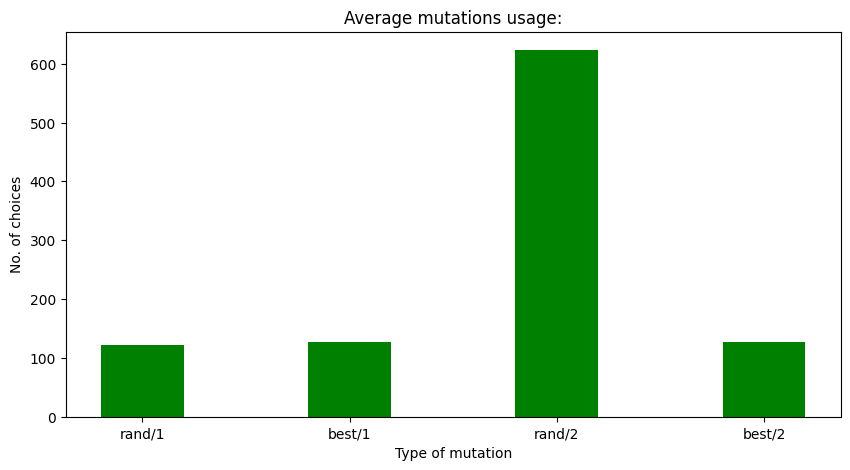

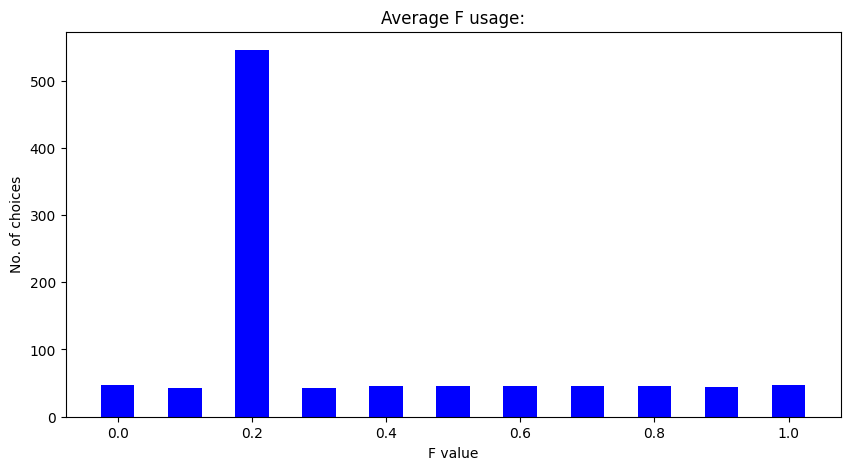

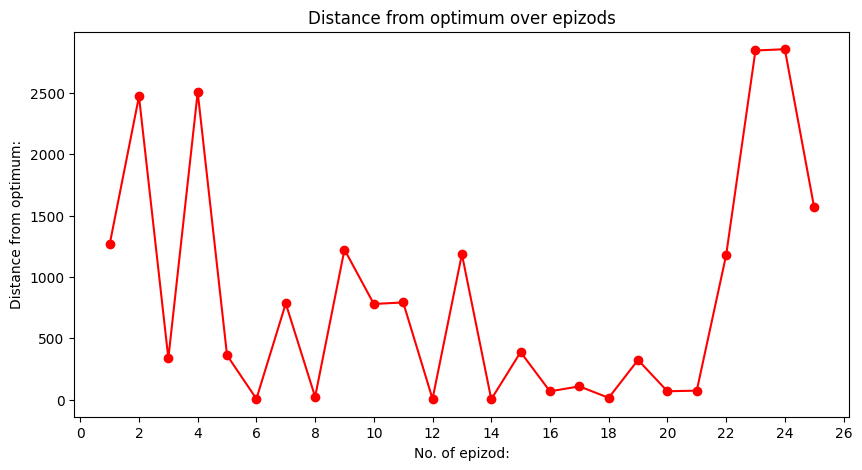

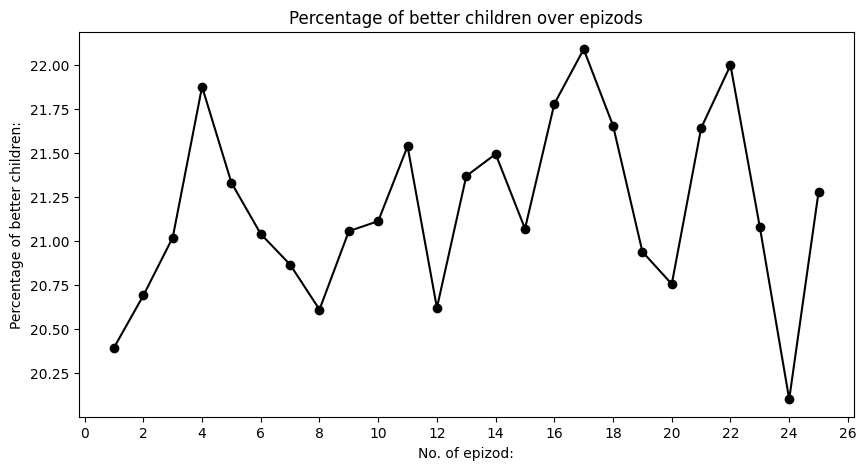

In [28]:
# Define the CR parameter and mutation strategy
CR = 0.5
mutation_strategies = ["rand/1", "best/1", "rand/2", "best/2"]

# Initialize the Q-values

# Define the mapping of the distance from the optimum, percentage of better children
state_mapping = {}  
discrete_distance = [10**x for x in range(15)]
discrete_percentage = [5*x for x in range(20)]
idx = 0
for dist in discrete_distance:
    for percentage in discrete_percentage:
        state_mapping[(dist, percentage)] = idx
        idx += 1

# Define the mapping of the actions to the f values, strategies
action_mapping = {}
discrete_f = [x/10 for x in range(11)]
discrete_strategies = [x for x in range(len(mutation_strategies))]
idx = 0
for f_value in discrete_f:
    for strategy in discrete_strategies:
        action_mapping[(f_value, strategy)] = idx
        idx += 1

# Define the number of episodes and maximum steps per episode
learning_rate = 0.1
discount_factor = 1
num_episodes = 25
max_steps = 1000

# Define variables to compare results over episodes
distances = []
children = []
fs = [0 for _ in discrete_f]
strategies = [0 for _ in mutation_strategies]
fs_map = {}
for _ in discrete_f:
    fs_map[_] = 0
# Q-learning algorithm
Q_values = np.zeros((len(state_mapping), len(action_mapping)))
for episode in range(num_episodes):
    # Reset the environment and get the initial state
    f_value = 0.5
    strategy = np.random.randint(0, 4)
    differential_evolution = DE(np.array(population))
    average_percentage_of_better_children = 0

    for step in range(max_steps):
        # Perform the DE optimization using the current F parameter, mutation strategy, and value

        # Compute the reward based on the performance of the DE optimization
        differential_evolution.nextGeneration(f_value, CR, mutation_strategies[strategy])
        distance_from_optimum = differential_evolution.evaluateOptimum()    # <0, ~1e14)
        percentage_of_better_children = differential_evolution.evaluateChildren() # <0, 100>
        
        #normalize two metrics and calulate reward
        magnitude = 1
        while(True):
            if(not int(distance_from_optimum / magnitude)):
                reward = -distance_from_optimum / (magnitude) * 10 # <0, 10>
                break
            magnitude *= 10

        reward += percentage_of_better_children # <0, 110>

        # Update the Q-value of the current state-action pair
        explore = np.random.random()
        if explore < (max_steps - step) / max_steps:
            next_f_value = np.random.choice(discrete_f)
            if next_f_value < 0:
               print("ALERT")
            next_strategy = np.random.randint(0, 4)
        else:
            optimal_state_idx, optimal_action_idx = np.unravel_index(np.argmax(Q_values), Q_values.shape)
            for action in action_mapping:
                if action_mapping[action] == optimal_action_idx:
                    next_f_value = action[0]
                    next_strategy = action[1]

        f_idx = min(discrete_f, key=lambda x:abs(x-f_value))
        next_f_idx = min(discrete_f, key=lambda x:abs(x-next_f_value))
        distance_from_optimum_idx = min(discrete_distance, key=lambda x:abs(x-distance_from_optimum))
        percentage_of_better_children_idx = min(discrete_percentage, key=lambda x:abs(x-percentage_of_better_children))
        
        state = (distance_from_optimum_idx, percentage_of_better_children_idx)
        action = (f_idx, strategy)
        next_action = (next_f_idx, next_strategy)

        state_id = state_mapping[state]
        action_id = action_mapping[action]
        next_action_id = action_mapping[next_action]

        fs_map[f_idx] += 1
        strategies[strategy] += 1

        # Update the Q-value of the current state-action pair
        Q_values[state_id, action_id] = (1 - learning_rate) * Q_values[state_id, action_id] + \
            learning_rate * (reward + discount_factor * (Q_values[state_id, next_action_id] - Q_values[state_id, action_id]))

        # Transition to the next state
        f_value = next_f_value
        strategy = next_strategy
        average_percentage_of_better_children += percentage_of_better_children

    # Select the optimal F parameter and mutation strategy based on learned Q-values
    optimal_state_idx, optimal_action_idx = np.unravel_index(np.argmax(Q_values), Q_values.shape)

    for state in state_mapping:
        if state_mapping[state] == optimal_state_idx:
            optimal_distance = state[0]
            optimal_percentage = state[1]

    for action in action_mapping:
        if action_mapping[action] == optimal_action_idx:
            optimal_f_value = action[0]
            optimal_strategy = action[1]

    average_percentage_of_better_children /= max_steps
    current_pop_distance = differential_evolution.evaluateOptimum()
    distances.append(current_pop_distance)
    children.append(average_percentage_of_better_children)
    fs.append(optimal_f_value)
    strategies.append(optimal_strategy)
    print(f'{episode + 1} / {num_episodes}, {(episode + 1) / num_episodes * 100}%')

print("Average precentage of better children:", np.average(children))
print("Current population distance from optiumum:", np.average(distances))
print("Min precentage of better children:", np.min(children))
print("Min Current population distance from optiumum:", np.min(distances))
print("Max Average precentage of better children:", np.max(children))
print("Max Current population distance from optiumum:", np.max(distances))
print(np.average(fs))
print(strategies[:4])
for x in range(len(mutation_strategies)):
    strategies[x] /= num_episodes
for x in fs_map:
    fs_map[x] /= num_episodes
drawPlotMutationTypes(mutation_strategies, strategies[:len(mutation_strategies)])
drawPlotFValues(discrete_f, fs_map.values())
drawDistances(distances, [x + 1 for x in range(num_episodes)])
drawPercentages(children, [x + 1 for x in range(num_episodes)])